# ノート 4: PyTorch の導入

### 目標: PyTorch の基本的な使い方を学ぶ

### 背景

[PyTorch]() は Facebook を中心としたオープンソースコミュニティによってメンテナンスされている機械学習パッケージです。

#### scikit-learn を使わないのはなぜですか？

scikit-learn には多層パーセプトロンのメソッドがありますが畳み込みニューラルネットワークは現時点でサポートされていません。
scikit-learn を使って ANN モデルの学習はできますが、PyTorch の方がより柔軟で研究や産業分野でも広く使われています。
PyTorch は GPU による計算もサポートしているので計算時間の大幅な削減が可能です。

#### PyTorch についてさらにチュートリアルを行う場合はどうすればよいですか？

PyTorch の公式ページ[チュートリアル]()にはパッケージの使い方の優れたチュートリアルがたくさんあります。
チュートリアルのデータセットは気象分野に関係したものではないので、気象分野の例に適用するのは簡単ではないかもしれません。


### Step 1: インポート


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # 不要な警告の抑止

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

print(f"NumPy  : {np.__version__}")
print(f"Pandas : {pd.__version__}")
print(f"PyTorch: {torch.__version__}")

# 再現性のため乱数を固定
_ = torch.manual_seed(42)

# jupyterのカスタマイズ
%config InlineBackend.figure_format = 'retina'

NumPy  : 1.26.3
Pandas : 2.2.0
PyTorch: 2.1.2+cpu


### Step 2: モデルの構築

ニューラルネットワークを構築する最も簡単な方法は `Sequential` クラスを利用する方法です。
クラス名が示す通り連続した層が一方通行に続くシンプルなモデルです。
入力データは `Sequential` モデルの各層を通って「流れていく」イメージです。

`Sequential` クラスを構成するのは `torch.nn.Module` クラスを継承したクラスで中間層や畳み込み層などです。

一つの例を実行してみましょう。まずは単純なパーセプトロンです。パーセプトロンは 1 つの層を持つネットワークです。


In [2]:
model = nn.Sequential(nn.Linear(1, 1))  # 入力1、出力1の線形レイヤー=パーセプトロン

これでニューラルネットワークモデルが作成できました。
PyTorch には Tensorflow の summary メソッドのようにモデル構造の詳細を可視化するメソッドはありません。
print 文で簡単な可視化はできますがサードパーティパッケージの torchinfo を使ってみます。


In [3]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            2
Total params: 2
Trainable params: 2
Non-trainable params: 0

各層の名前、形状、パラメーターの数を確認することができます。

作成したモデルは `Linear` クラスのみで構成され活性化関数を含みません。
このため、このモデルは非常にシンプルで式の上では線形回帰と同じになります。
すなわち、

$$y = wx+b$$

を表します。
$w$と$b$は 2 つの学習パラメータです。`Linear` クラスのパラメータは `weight` と `bias` 属性で確認できます。


In [4]:
print(model[0].weight)
print(model[0].bias)

Parameter containing:
tensor([[0.7645]], requires_grad=True)
Parameter containing:
tensor([0.8300], requires_grad=True)


`weight` は $w$、`bias` が $b$ です。
全てのパラメータの初期値が 0 だと多くの問題で ML は上手くいかないため重みをランダムに初期化する必要があります。
重みは多くの場合 0 から 1 の間のランダムな値で初期化されます。


### Step 3: データの読み込み

モデルを作成した時点で重みはランダムに初期化されています。
次はモデルにデータを与えて学習を行う必要があります。
sub-SEVIR データセットの特徴量ファイルを読み込んで IR 画像の輝度温度から発雷の数を予測させてみましょう。

データを読み込んで前処理を行います。csv ファイルは既に正規化してあります。どのような前処理を行うのかは Part1 のノート 5 を確認してみてください。


Text(0, 0.5, '$log_{10}(lightning flashes)$')

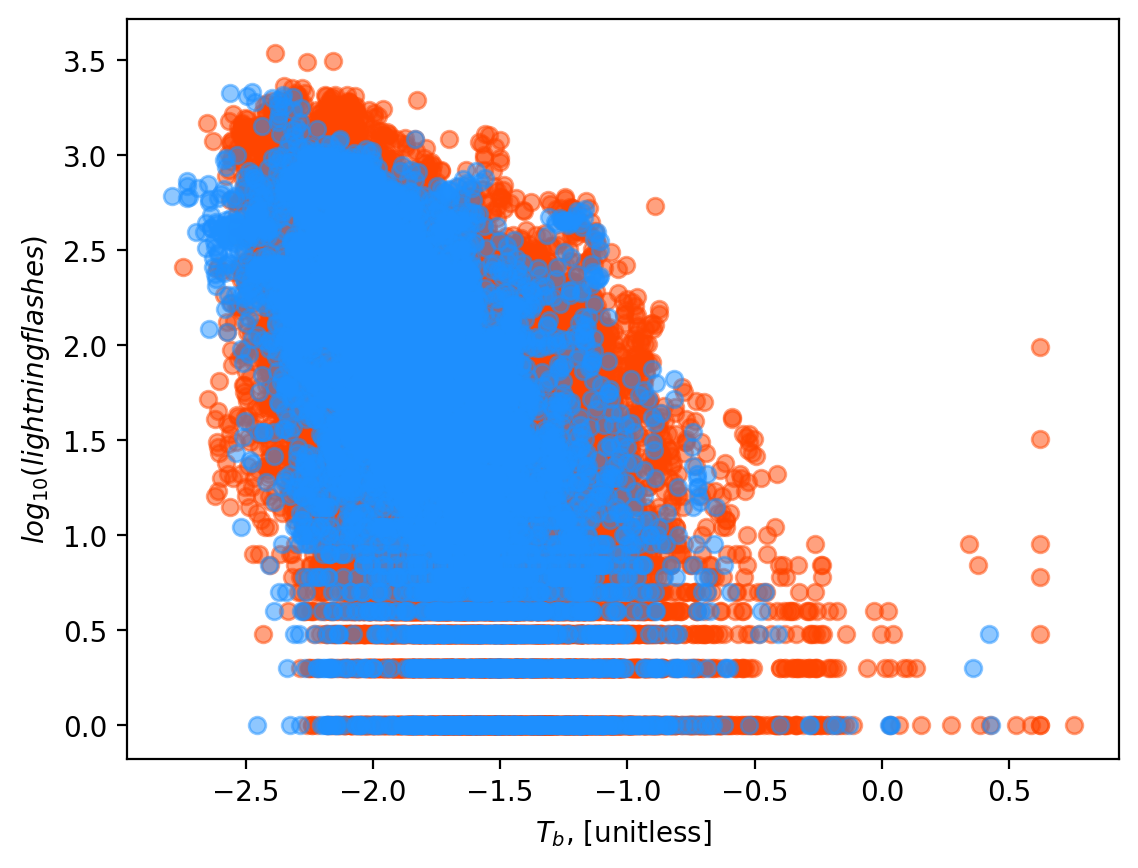

In [5]:
from pathlib import Path


save_dir = Path("../datasets/sub-sevir-engineered")
# 訓練データ
df_t = pd.read_csv(save_dir / "lowres_features_train.csv")
# 評価データ
df_v = pd.read_csv(save_dir / "lowres_features_val.csv")

# 発雷ありのデータのみ取り出す
df_t = df_t.where(df_t.label_reg > 0).dropna()
df_v = df_v.where(df_v.label_reg > 0).dropna()

# IR画像の最小輝度温度（q000_ir) を取り出してNumPy配列にする
X_t = df_t.iloc[:, 0].to_numpy()
# ラベル（発雷数）を取り出してNumPy配列にする、線形回帰モデルに適用するため対数に変換する
y_t = np.log10(df_t.iloc[:, 37].to_numpy())

X_v = df_v.iloc[:, 0].to_numpy()
y_v = np.log10(df_v.iloc[:, 37].to_numpy())

plt.plot(X_t, y_t, "o", color="orangered", alpha=0.5)
plt.plot(X_v, y_v, "o", color="dodgerblue", alpha=0.5)

plt.xlabel(r"$T_b$, [unitless]")
plt.ylabel(r"$log_{10}(lightning flashes)$")

まずはランダムに初期化されたパラメータを持つ未学習のモデルの予測がどうなるか見てみましょう。PyTorch では `model(x)` で 入力変数 `x` で呼び出すことで予測（出力）が取得できます。
PyTorch のモデルは `Tensor` 型を引数にとるので変換が必要なことに慣れていってください。

このモデルの場合は特徴量の数が 1 なので、（データ数、特徴量数=1）の形状で入力する必要があることに注意してください。


Text(0, 0.5, '$log_{10}(lightning flashes)$')

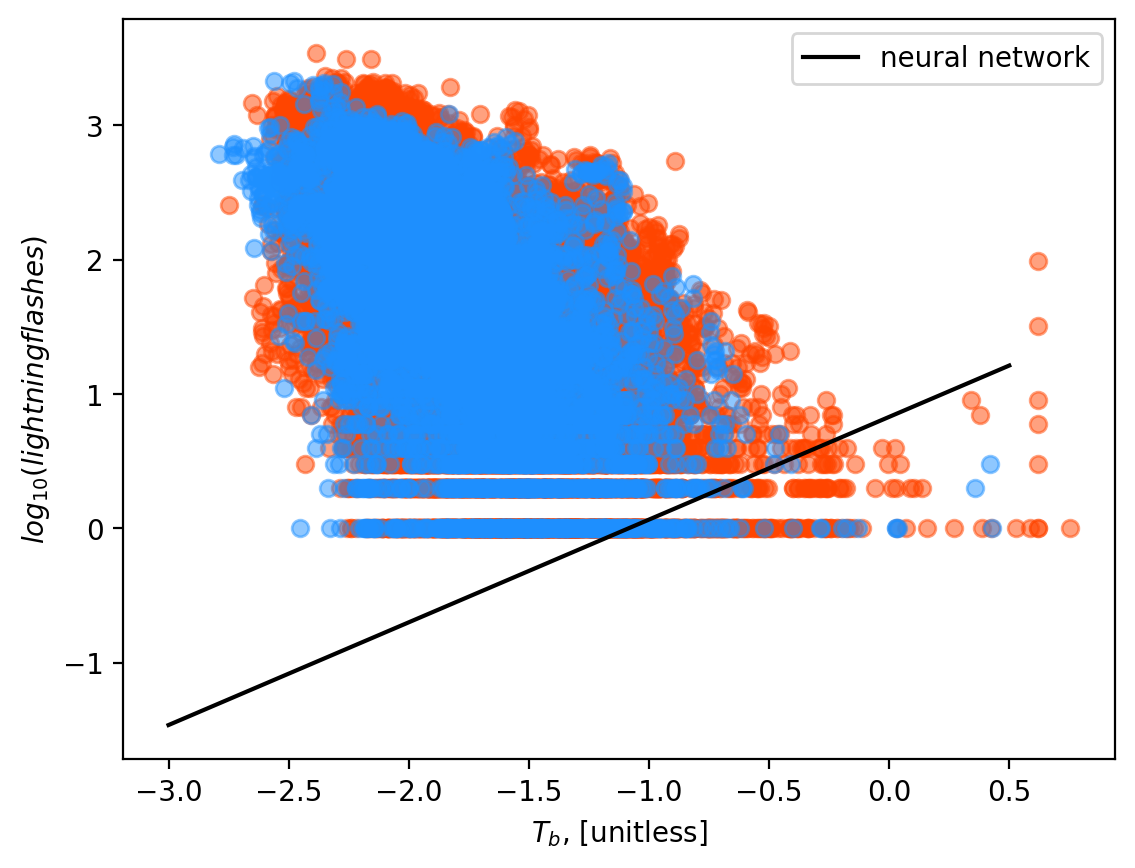

In [6]:
model.eval()  # 推論モードに変更、現時点ではおまじないだと考える

with torch.no_grad():  # 勾配計算を行わない、これもおまじない
    x = torch.linspace(-3, 0.5, 50)
    # nn.Linearが（バッチ数、特徴量数）の形状を入力に求めるので変形する
    yhat = model(x.view(-1, 1)).numpy()

plt.plot(X_t, y_t, "o", color="orangered", alpha=0.5)
plt.plot(X_v, y_v, "o", color="dodgerblue", alpha=0.5)

plt.plot(x, yhat[:,0], "-k", label="neural network")
plt.legend()
plt.xlabel("$T_b$, [unitless]")
plt.ylabel("$log_{10}(lightning flashes)$")

ランダムに初期化されたパラメータではうまく当てはまらないことが分かります。
上手く当てはまるようにするにはモデルを学習させる必要があるのです。


### Step 3: 損失関数と最適化手法

モデルの学習を始める前に損失関数と最適化の方法を設定する必要があります。
PyTorch では様々な損失関数、最適化方法に対応したクラスが用意されていて、対応するクラスをインスタンスして利用します。

この例では線形回帰と対応させるために損失関数を二乗平均誤差に最適化には勾配降下法を用います。


In [7]:
# 損失関数
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD(
    # 最適化させるモデルのパラメータ
    model.parameters(),
    # 学習率
    lr=0.01,
)

### Step 4: バッチとシャッフル

ニューラルネットワークの学習は「重み（パラメータ）をどう変化させると予測がよくなるか？」という問題に帰着します。
これは、「モデルの誤差を表す関数（損失関数）を最小化するようにパラメータを求める」最適化問題です。
これを次のように解いていきます。

1. 訓練データから小さなまとまり（ミニバッチ）のデータを取り出して損失関数の勾配を計算する。
2. 損失関数を現象させる勾配の方向に重みを変化させる。
3. また別のミニバッチを取り出して勾配を計算し重みを変化させる。

これをすべてのデータについて繰り返します。

データセットからミニバッチを取り出したりシャッフルするには PyTorch の `DataLoader` クラスを利用するのが簡単です。
訓練データの NumPy 配列から `Dataset` と `DataLoader` を作成しましょう。


In [8]:
from torch.utils.data import DataLoader, TensorDataset

# NumPy配列のデータを Tensor に変換して Dataset を作成
train_dataset = TensorDataset(
    torch.FloatTensor(X_t),
    torch.FloatTensor(y_t),
)

`Dataset` を引数にした`DataLoader` からループを回すことでミニバッチを取り出すことができます。


In [9]:
train_dataloader = DataLoader(train_dataset)
for batch, (X, y) in enumerate(train_dataloader):
    print(batch, X, y)
    if batch == 5:
        break

0 tensor([-2.1962]) tensor([2.7782])
1 tensor([-2.0970]) tensor([2.7443])
2 tensor([-2.1912]) tensor([2.6866])
3 tensor([-2.0699]) tensor([2.5515])
4 tensor([-2.0389]) tensor([2.6191])
5 tensor([-2.1858]) tensor([2.7574])


デフォルトのバッチサイズは 1 なのでループで取り出された 1 つのミニバッチのデータ `X`, `y` はデータ数は 1 の `Tensor` です。

`Tensor` という言葉を初めて聞いて戸惑うかもしれませんが今は気にする必要はありません。
`Tensor` は NumPy の配列にニューラルネットワークの勾配の計算を行う機能がついたようなデータ型で
PyTorch でモデルの学習、評価、テストを行う場合に使います。`DataLoader` から取り出すデータは自動的に `Tensor` に変換されます。

データをランダムに取り出す場合は `DataLoader` の `shuffle` オプションで指定します。


In [10]:
train_dataloader = DataLoader(train_dataset, shuffle=True)
for batch, (X, y) in enumerate(train_dataloader):
    print(batch, X, y)
    if batch == 5:
        break

0 tensor([-2.2331]) tensor([2.6794])
1 tensor([-1.7715]) tensor([1.9868])
2 tensor([-1.9754]) tensor([2.0492])
3 tensor([-1.6099]) tensor([0.6021])
4 tensor([-2.1869]) tensor([2.9528])
5 tensor([-1.1139]) tensor([1.9823])


今回は最適化手法には 確率的勾配降下法（SGD）を使います。
同じデータセットで何回か学習を繰り返す場合（1 つの全訓練データの学習の繰り返し数をエポック数といいます）取り出す順序をランダムに変化させることが重要になります（「確率的」という名称がついている理由です）。

`DataLoader` の `shuffle` オプションを指定すると、エポック毎に取り出されるデータがランダムに変化していることを確認しましょう。


In [11]:
train_dataloader = DataLoader(train_dataset, shuffle=True)

epochs = np.arange(0, 3)
for epoch in epochs:
    print(f"epoch {epoch}")
    for batch, (X, y) in enumerate(train_dataloader):
        if batch < 5:
            print(batch, X, y)
        else:
            pass

epoch 0
0 tensor([-2.2455]) tensor([1.3222])
1 tensor([-1.7459]) tensor([2.3962])
2 tensor([-2.1850]) tensor([2.2601])
3 tensor([-1.9013]) tensor([0.7782])
4 tensor([-0.1815]) tensor([0.])
epoch 1
0 tensor([-1.8622]) tensor([2.5599])
1 tensor([-2.0691]) tensor([1.3979])
2 tensor([-1.5940]) tensor([1.7993])
3 tensor([-1.4425]) tensor([0.7782])
4 tensor([-1.5650]) tensor([1.9138])
epoch 2
0 tensor([-0.8333]) tensor([0.4771])
1 tensor([-1.9254]) tensor([1.9243])
2 tensor([-1.9746]) tensor([2.1461])
3 tensor([-1.9796]) tensor([1.7634])
4 tensor([-1.2875]) tensor([1.2553])


データセットからミニバッチを取り出して勾配を計算するのはデータセット全てを使って勾配の計算を行うコストが非常に大きいからでした。
ミニバッチとして取り出した一部のデータから勾配を計算して近似することで徐々に正しい解に収束させていくことができます。

ミニバッチとして取り出すには `DataLoader` の `batch_size` オプションでバッチのサイズを指定するだけです。


In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

epochs = np.arange(0, 3)
for epoch in epochs:
    print(f"epoch {epoch}")
    for batch, (X, y) in enumerate(train_dataloader):
        if batch < 1:
            print(batch, X, y)
        else:
            pass

epoch 0
0 tensor([-1.8971, -2.1718, -1.9261, -1.2972, -2.1067, -1.4755, -1.6661, -2.1435,
        -2.0420, -1.3487, -1.9517, -1.9223, -1.8599, -1.1061, -1.9296, -1.7816,
        -2.0339, -1.0914, -2.2249, -1.8482, -2.2284, -1.3464, -1.6041, -0.8097,
        -2.3044, -2.2714, -2.0540, -2.0901, -2.1838, -1.9633, -1.9812, -1.0182]) tensor([0.3010, 2.4502, 2.2304, 1.8865, 2.3522, 1.7076, 0.0000, 2.4472, 1.9777,
        0.0000, 2.1959, 2.2648, 1.8513, 0.3010, 2.4669, 1.3010, 2.3324, 1.8195,
        3.0374, 0.0000, 3.1258, 1.4314, 0.6990, 1.0414, 2.8657, 2.4200, 1.8633,
        1.7076, 2.0086, 1.7634, 2.6551, 2.2279])
epoch 1
0 tensor([-1.6781, -1.5564, -1.2794, -1.6126, -2.3427, -1.9548, -2.0901, -1.6018,
        -1.5677, -1.7335, -2.1838, -2.2881, -2.2226, -2.3520, -2.3450, -1.9226,
        -1.1906, -1.7122, -1.8172, -2.0141, -1.9292, -1.7700, -2.1408, -1.7556,
        -1.5444, -1.3859, -0.9655, -2.1056, -1.0600, -1.8785, -1.8680, -1.0585]) tensor([1.4150, 0.4771, 0.9031, 0.6021, 2.8686, 1

`x` はサイズ (32, 1) のバッチで取り出されています。32 が 1 バッチのデータ数で DataLoader はバッチサイズを次元 0 に追加した `Tensor` を返すことに注意してください。
各バッチのデータはエポック毎にランダムに変化していることが確認できます。


### Step 5: モデルの学習


モデルの学習を行ってみましょう。
PyTorch の場合はバッチからモデルの出力を求めて勾配を計算しパラメータを更新する処理をループで繰り返します。


In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model.train()
for batch, (xb, yb) in enumerate(train_dataloader):
    # モデルの出力
    pred = model(xb.view(-1, 1)) # 0次元目がバッチ次元になるように変形
    # 損失関数の計算
    loss = loss_fn(pred, yb.view(-1, 1)) # 0次元目がバッチ次元になるように変形
    # 勾配の初期化
    optimizer.zero_grad()
    # 勾配の計算
    loss.backward()
    # パラメータ更新
    optimizer.step()

Text(0, 0.5, '$log_{10}(lightning flashes)$')

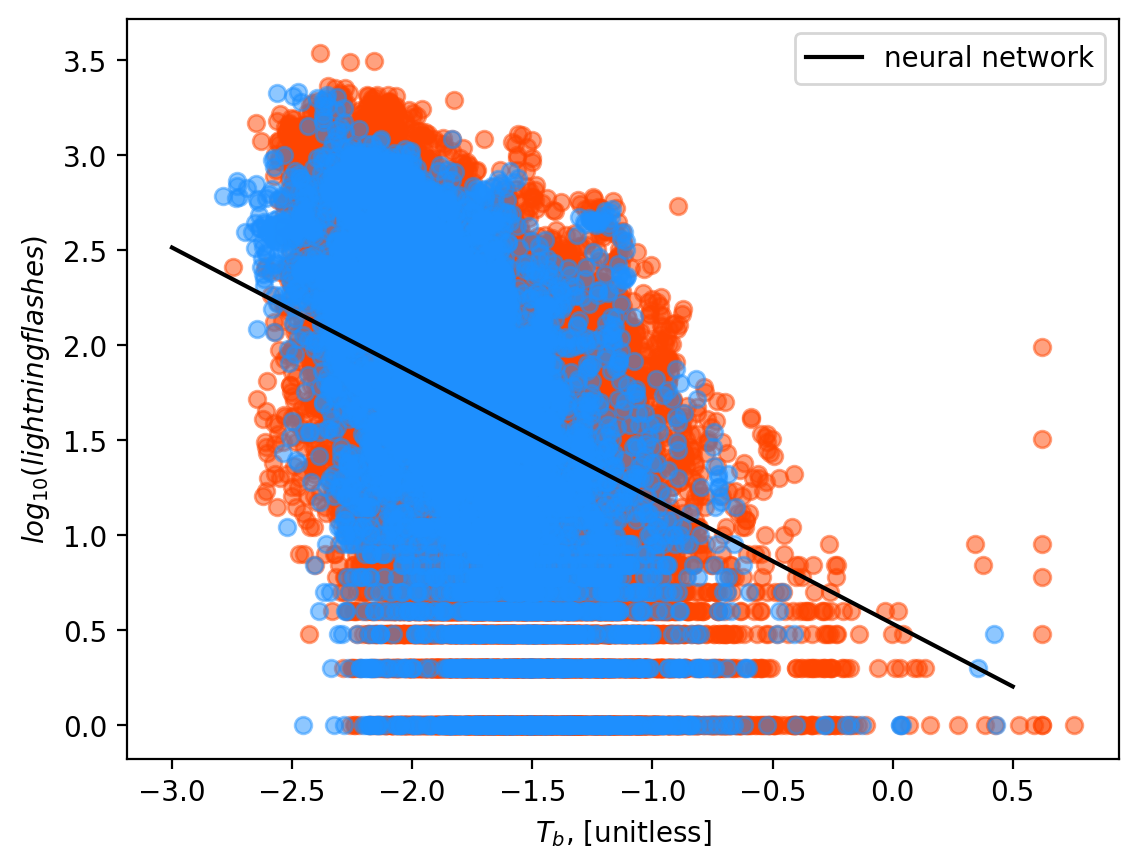

In [14]:
model.eval()  # 推論モードに変更

with torch.no_grad():  # 勾配計算を行わない（メモリ節約）
    x = torch.linspace(-3, 0.5, 50)
    yhat = model(x.view(-1, 1)).numpy()

plt.plot(X_t, y_t, "o", color="orangered", alpha=0.5)
plt.plot(X_v, y_v, "o", color="dodgerblue", alpha=0.5)

plt.plot(x, yhat[:,0], "-k", label="neural network")
plt.legend()
plt.xlabel("$T_b$, [unitless]")
plt.ylabel("$log_{10}(lightning flashes)$")

対応は悪くありませんね。通常はニューラルネットワークの学習には多くのエポック数が必要になりますが、
学習パラメータが 2 つだけのパーセプトロンというシンプルなモデルだったためそれほど学習量は必要ありませんでした。
この例の場合は線形回帰と基本的に同じであり線形回帰の方が学習が速いです。

学習で得られたパラメータを確認しましょう。


In [15]:
print(model[0].weight)
print(model[0].bias)

Parameter containing:
tensor([[-0.6603]], requires_grad=True)
Parameter containing:
tensor([0.5333], requires_grad=True)
